In [1]:
import torch.nn as nn
import torch
import random

In [33]:
class RECTRN(nn.Module):
    def __init__(self):
        super(RECTRN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # (32, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 16, 16)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 8, 8)
            nn.ReLU(),
        )

        self.fc_encode = nn.Linear(256 * 8 * 8, 256) 
        self.fc_float = nn.Linear(256 + 1, 256 * 8 * 8)  
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (3, 128, 128)
            nn.Sigmoid()  
        )
    
    def forward(self, x, action_id):
        encoded = self.encoder(x)
        encoded_flat = encoded.view(1, -1)[0]
        encoded_features = self.fc_encode(encoded_flat)
   
        combined = torch.cat((encoded_features, torch.tensor([action_id], dtype=torch.double)), dim=0)
        decoded_input = self.fc_float(combined).view(-1, 256, 8, 8)

        reconstructed = self.decoder(decoded_input)
        return reconstructed 

In [34]:
def train():
    image_normalization_tensor = torch.tensor([[[[255 for _ in range(128)] for _ in range(128)] for _ in range(3)] for _ in range(1000)], dtype=torch.double)

    model = RECTRN().double()

    model.train()
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    

    actions = torch.load("./training_data/actions.pt", weights_only=True)
    actions = torch.tensor(actions, dtype=torch.double)


    before_imgs = torch.load("./training_data/before_imgs.pt", weights_only=True)
    before_imgs = before_imgs / image_normalization_tensor
    before_imgs = torch.tensor(before_imgs, dtype=torch.double)

    after_imgs = torch.load("./training_data/after_imgs.pt", weights_only=True)
    after_imgs = after_imgs / image_normalization_tensor
    after_imgs = torch.tensor(after_imgs, dtype=torch.double)

    lossLst = []

    criterion = nn.MSELoss()
    for i in range(10_000):
        ind = random.randint(0, 999)
        optimizer.zero_grad()
        out = model(before_imgs[ind] , actions[ind] / 4)
        loss = criterion(out, after_imgs[ind])
        lossLst.append(loss.item())
        loss.backward()
        optimizer.step()

        if (i % 100 == 0):
            print(f"Epoch: {i} done")
    return model, lossLst  

In [35]:
model, lossLst = train()


/tmp/ipykernel_52452/687183751.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.double)
/tmp/ipykernel_52452/687183751.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  before_imgs = torch.tensor(before_imgs, dtype=torch.double)
/tmp/ipykernel_52452/687183751.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after_imgs = torch.tensor(after_imgs, dtype=torch.double)
/home/deniz/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target siz

Epoch: 0 done
Epoch: 100 done
Epoch: 200 done
Epoch: 300 done
Epoch: 400 done
Epoch: 500 done
Epoch: 600 done
Epoch: 700 done
Epoch: 800 done
Epoch: 900 done
Epoch: 1000 done
Epoch: 1100 done
Epoch: 1200 done
Epoch: 1300 done
Epoch: 1400 done
Epoch: 1500 done
Epoch: 1600 done
Epoch: 1700 done
Epoch: 1800 done
Epoch: 1900 done
Epoch: 2000 done
Epoch: 2100 done
Epoch: 2200 done
Epoch: 2300 done
Epoch: 2400 done
Epoch: 2500 done
Epoch: 2600 done
Epoch: 2700 done
Epoch: 2800 done
Epoch: 2900 done
Epoch: 3000 done
Epoch: 3100 done
Epoch: 3200 done
Epoch: 3300 done
Epoch: 3400 done
Epoch: 3500 done
Epoch: 3600 done
Epoch: 3700 done
Epoch: 3800 done
Epoch: 3900 done
Epoch: 4000 done
Epoch: 4100 done
Epoch: 4200 done
Epoch: 4300 done
Epoch: 4400 done
Epoch: 4500 done
Epoch: 4600 done
Epoch: 4700 done
Epoch: 4800 done
Epoch: 4900 done
Epoch: 5000 done
Epoch: 5100 done
Epoch: 5200 done
Epoch: 5300 done
Epoch: 5400 done
Epoch: 5500 done
Epoch: 5600 done
Epoch: 5700 done
Epoch: 5800 done
Epoch: 59

/tmp/ipykernel_52452/706432961.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


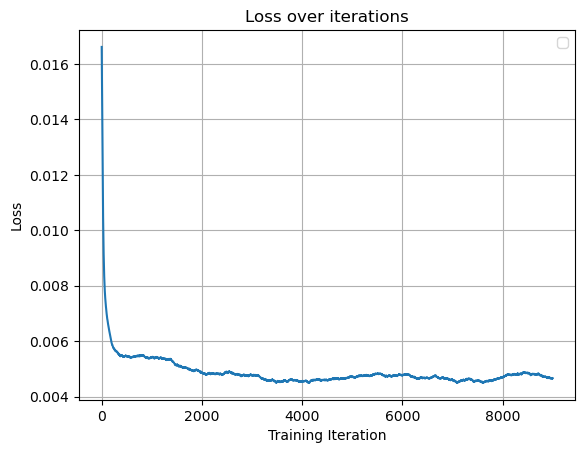

In [36]:
import numpy as np
import matplotlib.pyplot as plt


loss_data = np.array(lossLst)

# Smoothing window size
window_size = 1000


smoothed_loss = np.convolve(loss_data, np.ones(window_size)/window_size, mode='valid')
lossX = [i for i in range(len(smoothed_loss))]

plt.plot(lossX, smoothed_loss)
plt.title("Loss over iterations")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


In [37]:
model.eval()
torch.save(model.state_dict(), "./models/Reconstruction.pth")


/tmp/ipykernel_52452/1951636906.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/Reconstruction.pth"))
/tmp/ipykernel_52452/195

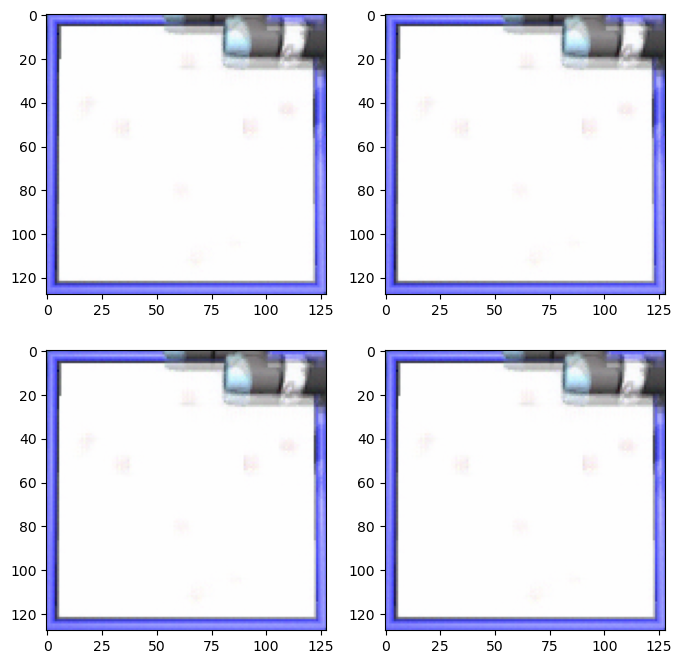

In [44]:
import matplotlib.pyplot as plt
def test():
    model = RECTRN().double()
    model.load_state_dict(torch.load("./models/Reconstruction.pth"))
    model.eval()

    image_normalization_tensor = torch.tensor([[[[255 for _ in range(128)] for _ in range(128)] for _ in range(3)] for _ in range(100)], dtype=torch.double)
    actions = torch.load("./test_data/actions.pt", weights_only=True)

    before_imgs = torch.load("./test_data/before_imgs.pt", weights_only=True)
    before_imgs = before_imgs / image_normalization_tensor

    actions = torch.tensor(actions, dtype=torch.double)

    test_idxs = [random.randint(0,99) for _ in range(4)]

    randimages = [before_imgs[test_idxs[0]], before_imgs[test_idxs[1]], before_imgs[test_idxs[2]], before_imgs[test_idxs[3]]]
    randactions = [actions[test_idxs[0]], actions[test_idxs[1]], actions[test_idxs[2]], actions[test_idxs[3]]]

    out0 = model(randimages[0], randactions[0])
    reconstructed0 = out0.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

    out1 = model(randimages[1], randactions[1])
    reconstructed1 = out1.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

    out2 = model(randimages[2], randactions[2])
    reconstructed2 = out2.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

    out3 = model(randimages[3], randactions[3])
    reconstructed3 = out3.squeeze().detach().cpu().numpy().transpose(1, 2, 0)


    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    axes[0,0].imshow(reconstructed0)
    axes[0,1].imshow(reconstructed1)
    axes[1,0].imshow(reconstructed2)
    axes[1,1].imshow(reconstructed3)



   
        
test()   